In [129]:
## import

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from sklearn.feature_selection import RFECV
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor as RFR
from IPython.display import display
from sklearn.decomposition import PCA

%matplotlib inline
plt.style.use('ggplot')

color_list = list(plt.rcParams['axes.prop_cycle'])
colors = [color_list[i]['color'] for i in range(len(color_list))]

In [2]:
origin = pd.read_csv('train.csv', index_col='id', )

df_train = origin.rename(columns={'spacegroup' : 'sg',
                            'number_of_total_atoms' : 'n_atoms',
                            'percent_atom_al' : 'x_Al',
                            'percent_atom_ga' : 'x_Ga',
                            'percent_atom_in' : 'x_In',
                            'lattice_vector_1_ang' : 'a',
                            'lattice_vector_2_ang' : 'b',
                            'lattice_vector_3_ang' : 'c',
                            'lattice_angle_alpha_degree' : 'alpha',
                            'lattice_angle_beta_degree' : 'beta',
                            'lattice_angle_gamma_degree' : 'gamma',
                            'formation_energy_ev_natom' : 'Ef',
                            'bandgap_energy_ev' : 'Eg'})


pd.set_option("display.max_rows",51)
df_train.head()

,sg,n_atoms,x_Al,x_Ga,x_In,a,b,c,alpha,beta,gamma,Ef,Eg
id,,,,,,,,,,,,,
1,33,80.0,0.6250,0.3750,0.000,9.9523,8.5513,9.1775,90.0026,90.0023,90.0017,0.0680,3.4387
2,194,80.0,0.6250,0.3750,0.000,6.1840,6.1838,23.6287,90.0186,89.9980,120.0025,0.2490,2.9210
3,227,40.0,0.8125,0.1875,0.000,9.7510,5.6595,13.9630,90.9688,91.1228,30.5185,0.1821,2.7438
4,167,30.0,0.7500,0.0000,0.250,5.0036,5.0034,13.5318,89.9888,90.0119,120.0017,0.2172,3.3492
5,194,80.0,0.0000,0.6250,0.375,6.6614,6.6612,24.5813,89.9960,90.0006,119.9893,0.0505,1.3793


### New features

In [3]:
import pymatgen as mg

## diffenence of In and Al
df_train['diff_In_Al'] = df_train['x_In'] - df_train['x_Al']

## volume
def get_vol(a, b, c, alpha, beta, gamma):
    return a*b*c*np.sqrt(1 + 2*np.cos(alpha)*np.cos(beta)*np.cos(gamma)
                           - np.cos(alpha)**2
                           - np.cos(beta)**2
                           - np.cos(gamma)**2)

# convert lattice angles from degrees to radians for volume calculation
lattice_angles = ['alpha', 'beta', 'gamma']
for lang in lattice_angles:
    df_train['_'.join([lang, 'r'])] = np.pi * df_train[lang] / 180
    
# compute the cell volumes
df_train['vol'] = get_vol(df_train['a'], df_train['b'], df_train['c'],
                          df_train['alpha_r'], df_train['beta_r'], df_train['gamma_r'])


## atomic density
df_train['atomic_density'] = df_train['n_atoms'] / df_train['vol']

## average size
Al = mg.Element("Al")
Ga = mg.Element("Ga")
In = mg.Element("In")

df_train['avg_size_calc'] = (df_train['x_In']*In.atomic_radius_calculated**3 + 
                  df_train['x_Al']*Al.atomic_radius_calculated**3 + 
                  df_train['x_Ga']*Ga.atomic_radius_calculated**3)*df_train['n_atoms']/df_train['vol']

df_train.head()

,sg,n_atoms,x_Al,x_Ga,x_In,a,b,c,alpha,beta,gamma,Ef,Eg,diff_In_Al,alpha_r,beta_r,gamma_r,vol,atomic_density,avg_size_calc
id,,,,,,,,,,,,,,,,,,,,
1,33,80.0,0.6250,0.3750,0.000,9.9523,8.5513,9.1775,90.0026,90.0023,90.0017,0.0680,3.4387,-0.6250,1.570842,1.570836,1.570826,781.052081,0.102426,0.201799
2,194,80.0,0.6250,0.3750,0.000,6.1840,6.1838,23.6287,90.0186,89.9980,120.0025,0.2490,2.9210,-0.6250,1.571121,1.570761,2.094439,782.500110,0.102236,0.201425
3,227,40.0,0.8125,0.1875,0.000,9.7510,5.6595,13.9630,90.9688,91.1228,30.5185,0.1821,2.7438,-0.8125,1.587705,1.590393,0.532648,391.227531,0.102242,0.184712
4,167,30.0,0.7500,0.0000,0.250,5.0036,5.0034,13.5318,89.9888,90.0119,120.0017,0.2172,3.3492,-0.5000,1.570601,1.571004,2.094425,293.377334,0.102257,0.223062
5,194,80.0,0.0000,0.6250,0.375,6.6614,6.6612,24.5813,89.9960,90.0006,119.9893,0.0505,1.3793,0.3750,1.570727,1.570807,2.094208,944.713843,0.084682,0.253691


In [15]:
## add new properties
prop = pd.read_csv('prop.csv', index_col='elm')

def get_avg_prop(name):
    return (df_train['x_In']*prop[name]['In'] + df_train['x_Al']*prop[name]['Al'] + df_train['x_Ga']*prop[name]['Ga'])*df_train['atomic_density']
    
for p in list(prop):
    df_train['_'.join(['avg', p])] = get_avg_prop(p)

df_train.head()

,sg,n_atoms,x_Al,x_Ga,x_In,a,b,c,alpha,beta,...,avg_size_calc,avg_EA,avg_EN,avg_HOMO,avg_IP,avg_LUMO,avg_mass,avg_rd_max,avg_rp_max,avg_rs_max
id,,,,,,,,,,,,,,,,,,,,,
1,33,80.0,0.6250,0.3750,0.000,9.9523,8.5513,9.1775,90.0026,90.0023,...,0.201799,-0.020559,0.172588,-0.277587,-0.593489,0.028551,4.405298,0.282055,0.147109,0.110364
2,194,80.0,0.6250,0.3750,0.000,6.1840,6.1838,23.6287,90.0186,89.9980,...,0.201425,-0.020521,0.172268,-0.277073,-0.592391,0.028498,4.397146,0.281534,0.146837,0.110160
3,227,40.0,0.8125,0.1875,0.000,9.7510,5.6595,13.9630,90.9688,91.1228,...,0.184712,-0.023364,0.168444,-0.276418,-0.591693,0.033063,3.578027,0.299762,0.150104,0.112850
4,167,30.0,0.7500,0.0000,0.250,5.0036,5.0034,13.5318,89.9888,90.0119,...,0.223062,-0.027645,0.168980,-0.278012,-0.584846,0.045990,5.004543,0.288110,0.150574,0.114528
5,194,80.0,0.0000,0.6250,0.375,6.6614,6.6612,24.5813,89.9960,90.0006,...,0.253691,-0.015645,0.152321,-0.233002,-0.483778,0.028951,7.336285,0.175926,0.114532,0.087010


In [5]:
## save data
df_train.to_csv('train_new_features.csv')

In [6]:
## prepare features for testing

## read data
origin = pd.read_csv('test.csv', index_col='id')
df_test = origin.rename(columns={'spacegroup' : 'sg',
                            'number_of_total_atoms' : 'n_atoms',
                            'percent_atom_al' : 'x_Al',
                            'percent_atom_ga' : 'x_Ga',
                            'percent_atom_in' : 'x_In',
                            'lattice_vector_1_ang' : 'a',
                            'lattice_vector_2_ang' : 'b',
                            'lattice_vector_3_ang' : 'c',
                            'lattice_angle_alpha_degree' : 'alpha',
                            'lattice_angle_beta_degree' : 'beta',
                            'lattice_angle_gamma_degree' : 'gamma',
                            'formation_energy_ev_natom' : 'Ef',
                            'bandgap_energy_ev' : 'Eg'})
display(df_test.head())


## diffenence of In and Al
df_test['diff_In_Al'] = df_test['x_In'] - df_test['x_Al']


## volume
def get_vol(a, b, c, alpha, beta, gamma):
    return a*b*c*np.sqrt(1 + 2*np.cos(alpha)*np.cos(beta)*np.cos(gamma)
                           - np.cos(alpha)**2
                           - np.cos(beta)**2
                           - np.cos(gamma)**2)

# convert lattice angles from degrees to radians for volume calculation
lattice_angles = ['alpha', 'beta', 'gamma']
for lang in lattice_angles:
    df_test['_'.join([lang, 'r'])] = np.pi * df_test[lang] / 180
    
# compute the cell volumes
df_test['vol'] = get_vol(df_test['a'], df_test['b'], df_test['c'],
                          df_test['alpha_r'], df_test['beta_r'], df_test['gamma_r'])


## atomic density
df_test['atomic_density'] = df_test['n_atoms'] / df_test['vol']


## average size
Al = mg.Element("Al")
Ga = mg.Element("Ga")
In = mg.Element("In")

df_test['avg_size_calc'] = (df_test['x_In']*In.atomic_radius_calculated**3 + 
                  df_test['x_Al']*Al.atomic_radius_calculated**3 + 
                  df_test['x_Ga']*Ga.atomic_radius_calculated**3)*df_test['n_atoms']/df_test['vol']

display(df_test.head())


## add new properties
prop = pd.read_csv('prop.csv', index_col='elm')

def get_avg_prop(name):
    return (df_test['x_In']*prop[name]['In'] + df_test['x_Al']*prop[name]['Al'] + df_test['x_Ga']*prop[name]['Ga'])*df_test['atomic_density']

for p in list(prop):
    df_test['_'.join(['avg', p])] = get_avg_prop(p)

display(df_test.head())


## save test data
df_test.to_csv('test_new_features.csv')

,sg,n_atoms,x_Al,x_Ga,x_In,a,b,c,alpha,beta,gamma
id,,,,,,,,,,,
1,33,80.0,0.1875,0.4688,0.3438,10.5381,9.0141,9.6361,89.9997,90.0003,90.0006
2,33,80.0,0.7500,0.2500,0.0000,9.8938,8.5014,9.1298,90.0038,90.0023,90.0015
3,167,30.0,0.6667,0.1667,0.1667,4.9811,4.9808,13.4799,89.9900,90.0109,120.0014
4,12,80.0,0.5625,0.4375,0.0000,24.3370,6.0091,5.7620,89.9995,103.8581,90.0002
5,12,80.0,0.1875,0.5000,0.3125,24.6443,6.2906,6.1589,90.0000,104.5929,90.0001


,sg,n_atoms,x_Al,x_Ga,x_In,a,b,c,alpha,beta,gamma,diff_In_Al,alpha_r,beta_r,gamma_r,vol,atomic_density,avg_size_calc
id,,,,,,,,,,,,,,,,,,
1,33,80.0,0.1875,0.4688,0.3438,10.5381,9.0141,9.6361,89.9997,90.0003,90.0006,0.1563,1.570791,1.570802,1.570807,915.347470,0.087399,0.244062
2,33,80.0,0.7500,0.2500,0.0000,9.8938,8.5014,9.1298,90.0038,90.0023,90.0015,-0.7500,1.570863,1.570836,1.570823,767.917987,0.104178,0.193889
3,167,30.0,0.6667,0.1667,0.1667,4.9811,4.9808,13.4799,89.9900,90.0109,120.0014,-0.5000,1.570622,1.570987,2.094420,289.624655,0.103582,0.222453
4,12,80.0,0.5625,0.4375,0.0000,24.3370,6.0091,5.7620,89.9995,103.8581,90.0002,-0.5625,1.570788,1.812666,1.570800,818.126773,0.097784,0.197986
5,12,80.0,0.1875,0.5000,0.3125,24.6443,6.2906,6.1589,90.0000,104.5929,90.0001,0.1250,1.570796,1.825490,1.570798,923.997043,0.086580,0.238284


,sg,n_atoms,x_Al,x_Ga,x_In,a,b,c,alpha,beta,...,avg_size_calc,avg_EA,avg_EN,avg_HOMO,avg_IP,avg_LUMO,avg_mass,avg_rd_max,avg_rp_max,avg_rs_max
id,,,,,,,,,,,,,,,,,,,,,
1,33,80.0,0.1875,0.4688,0.3438,10.5381,9.0141,9.6361,89.9997,90.0003,...,0.244062,-0.018019,0.154028,-0.239786,-0.499489,0.032240,6.748878,0.197757,0.120840,0.091832
2,33,80.0,0.7500,0.2500,0.0000,9.8938,8.5014,9.1298,90.0038,90.0023,...,0.193889,-0.022841,0.172935,-0.281879,-0.603143,0.032139,3.924055,0.299251,0.151839,0.114075
3,167,30.0,0.6667,0.1667,0.1667,4.9811,4.9808,13.4799,89.9900,90.0109,...,0.222453,-0.024962,0.173173,-0.281496,-0.595236,0.039659,5.049802,0.285567,0.150554,0.113952
4,12,80.0,0.5625,0.4375,0.0000,24.3370,6.0091,5.7620,89.9995,103.8581,...,0.197986,-0.018722,0.165989,-0.265222,-0.566828,0.025803,4.466880,0.263468,0.139404,0.104507
5,12,80.0,0.1875,0.5000,0.3125,24.6443,6.2906,6.1589,90.0000,104.5929,...,0.238284,-0.017296,0.152652,-0.237376,-0.495524,0.030406,6.562892,0.196483,0.119535,0.090693


### Data analysis and plots

In [135]:
## plot feature importance
def plot_xy(data, x_name, y_name):
    plt.xlabel(x_name)
    plt.ylabel(y_name)
    plt.scatter(data[x_name], data[y_name], alpha=0.5)

def feature_importance(data, x_names, y_name, selector):
    X = data[x_names].values
    y = data[y_name].values
    selector.fit(X, y)
    importances = selector.feature_importances_
    indices = np.argsort(importances)[::-1]
    sorted_features = [x_names[idx] for idx in indices]

    fig = plt.figure(figsize=(12, 5))
    plt.subplot()
    plt.xlabel('features')
    plt.ylabel('importance')
    plt.bar(range(X.shape[1]), importances[indices], align="center", color=colors[1])
    plt.xticks(range(X.shape[1]), sorted_features, rotation=90)
    
    plt.show()
    return sorted_features

def plot_features(data, sorted_features, y_name, n):
    fig = plt.figure(figsize=(16,6*(n//2+1)))
    for i in range(n):
        a = str(n//2+1)+'2'+str(i+1)
        plt.subplot(a)
        plot_xy(data, sorted_features[i], y_name)
    plt.show()

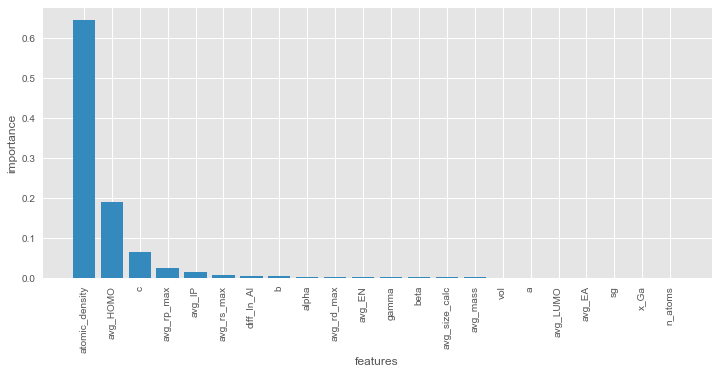

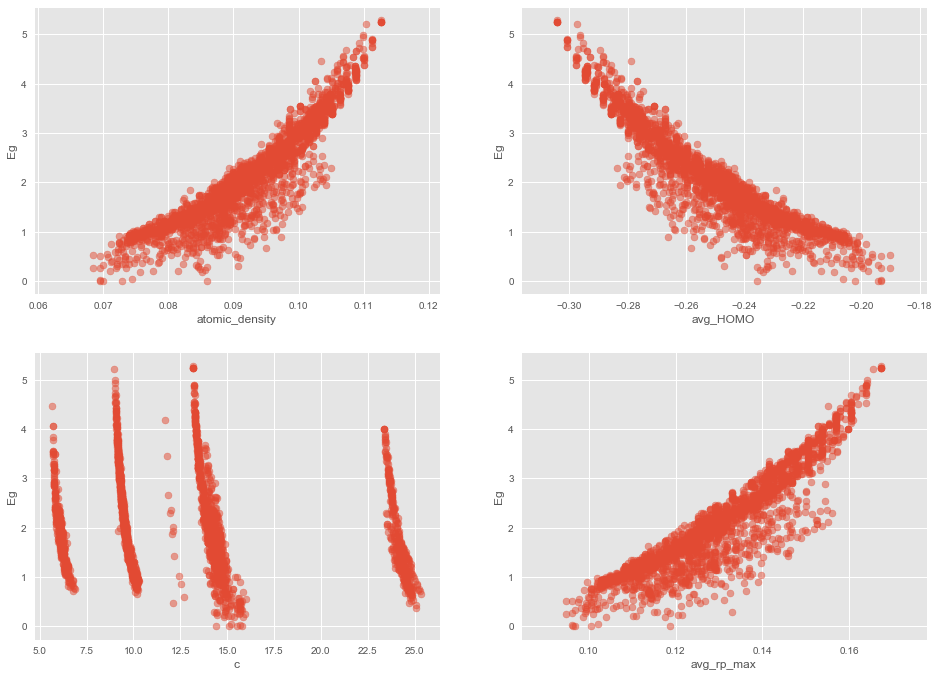

In [136]:
## plot for bandgap energy

exclude_feature = ['alpha_r', 'beta_r', 'gamma_r', 'x_In', 'x_Al']
data_train = df_train.drop(exclude_feature, axis=1)
features = list(data_train.drop(['Ef', 'Eg'], axis=1))

selector = RFR(n_estimators=50, max_depth=10, random_state=0)
sorted_features = feature_importance(data_train, features, 'Eg', selector)
plot_features(df_train, sorted_features, 'Eg', 4)

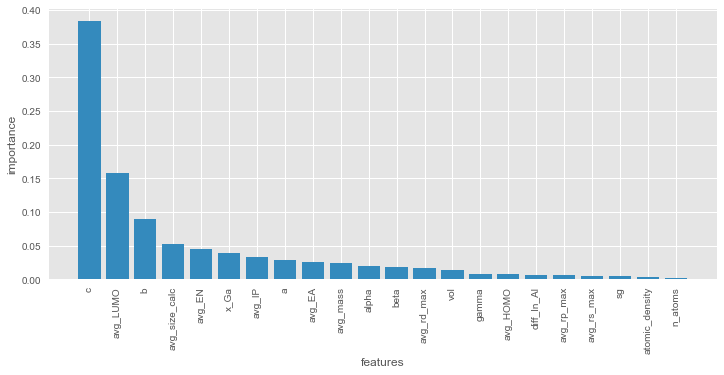

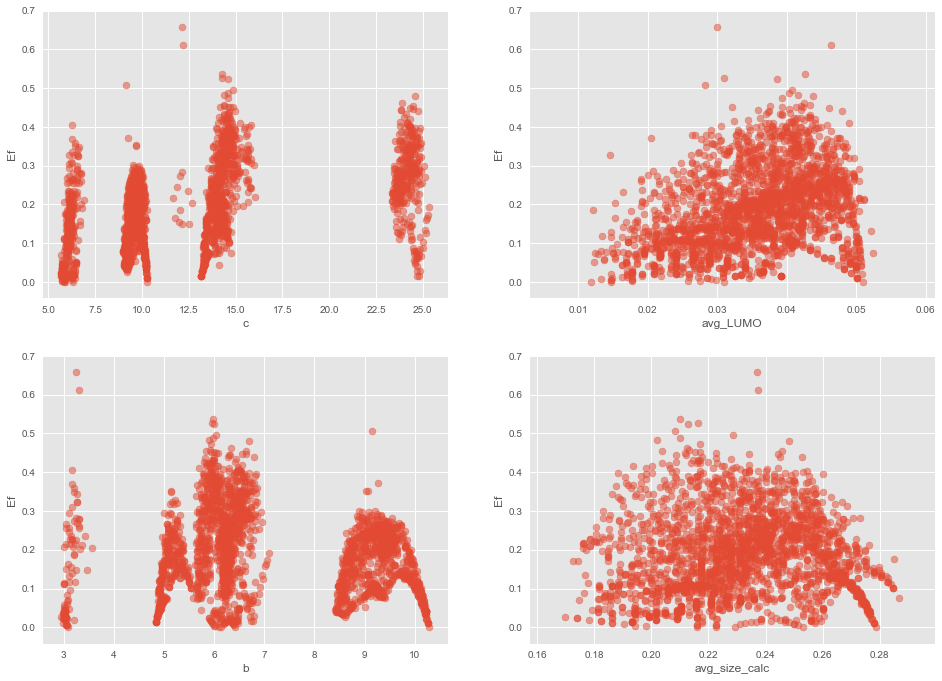

In [137]:
## plot for formation energy

sorted_features = feature_importance(data_train, features, 'Ef', selector)
plot_features(df_train, sorted_features, 'Ef', 4)

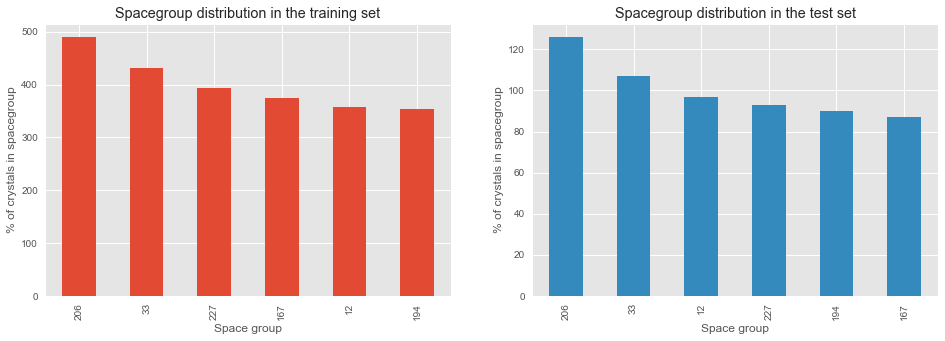

In [134]:
## plot the Spacegroup distribution

fig = plt.figure(figsize=(16, 5))
plt.subplot(121)
df_train['sg'].value_counts().plot.bar()
plt.title('Spacegroup distribution in the training set')
plt.ylabel('% of crystals in spacegroup')
plt.xlabel('Space group')
plt.subplot(122)
df_test['sg'].value_counts().plot.bar(color=colors[1])
plt.title('Spacegroup distribution in the test set')
plt.ylabel('% of crystals in spacegroup')
plt.xlabel('Space group')
plt.show()

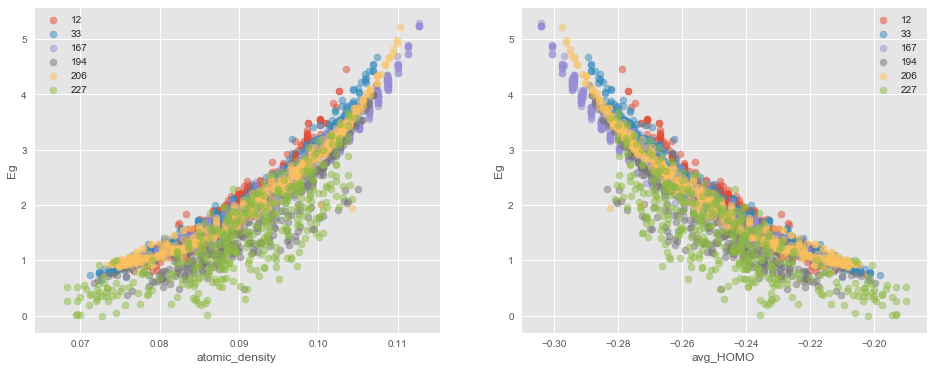

In [145]:
## Analyse each space group

group_sg = df_train.groupby(['sg'])

keys = []
fig = plt.figure(figsize=(16,6))
plt.subplot(121)
for i, (key, group) in enumerate(group_sg):
    keys.append(key)
    plt.xlabel('atomic_density')
    plt.ylabel('Eg')
    plt.scatter(group['atomic_density'], group['Eg'], alpha=0.5)
plt.legend(keys)

plt.subplot(122)
for i, (name, group) in enumerate(group_sg):
    plt.xlabel('avg_HOMO')
    plt.ylabel('Eg')
    plt.scatter(group['avg_HOMO'], group['Eg'], alpha=0.5)
plt.legend(keys)
plt.show()

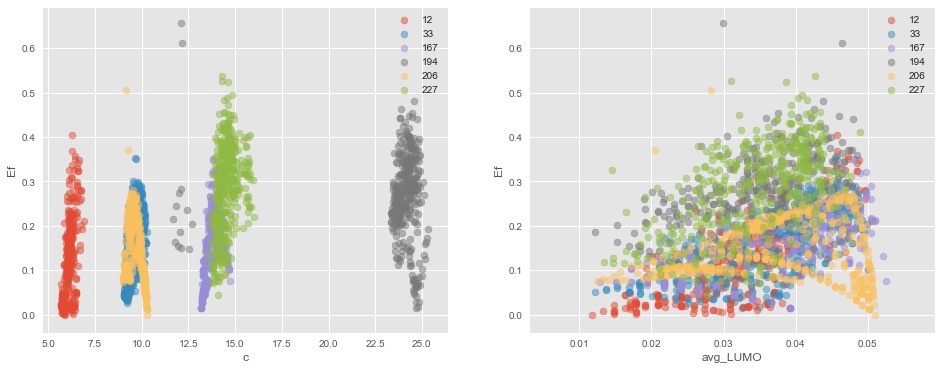

In [97]:
fig = plt.figure(figsize=(16,6))
plt.subplot(121)
for i, (name, group) in enumerate(group_sg):
    plt.xlabel('c')
    plt.ylabel('Ef')
    plt.scatter(group['c'], group['Ef'], alpha=0.5)
plt.legend(keys)

plt.subplot(122)
for i, (name, group) in enumerate(group_sg):
    plt.xlabel('avg_LUMO')
    plt.ylabel('Ef')
    plt.scatter(group['avg_LUMO'], group['Ef'], alpha=0.5)
plt.legend(keys)
plt.show()

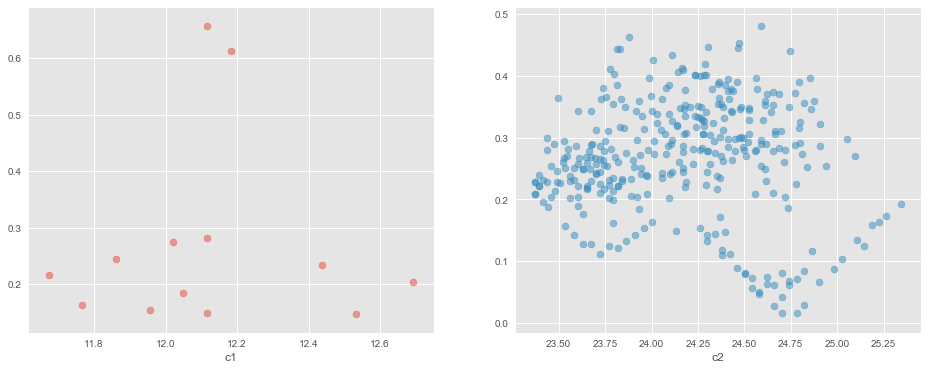

In [144]:
subgroup = group_sg.get_group(194)
c1 = subgroup[subgroup['c']<20]
c2 = subgroup[subgroup['c']>20]

plt.figure(figsize=(16,6))
plt.subplot(121)
plt.xlabel('c1')
plt.scatter(c1['c'], c1['Ef'], alpha=0.5)
plt.subplot(122)
plt.xlabel('c2')
plt.scatter(c2['c'], c2['Ef'], alpha=0.5, color=colors[1])
plt.show()

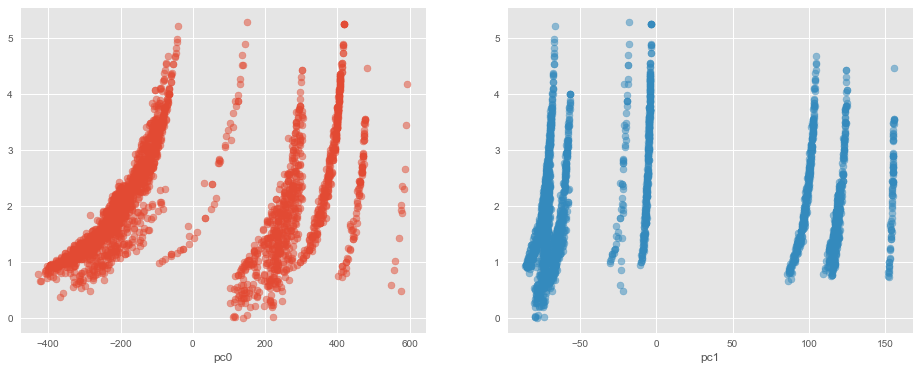

In [143]:
## PCA
pca = PCA(n_components=2)
X = data_train[features]
X_pca = pca.fit_transform(X)

plt.figure(figsize=(16,6))
plt.subplot(121)
plt.xlabel('pc0')
plt.scatter(X_pca[:,0], data_train['Eg'], alpha=0.5)
plt.subplot(122)
plt.xlabel('pc1')
plt.scatter(X_pca[:,1], data_train['Eg'], alpha=0.5, color=colors[1])
plt.show()